In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model

In [11]:
def loadDataFiles():
    market_df = pickle.load(open('Market_train',"rb"))
    news_df = pickle.load(open("News_train", "rb"))
    print('Finished loading datafiles!')
    return market_df, news_df


In [12]:
def preprocess_data(mkt_df, news_df):
    mkt_df['time'] = pd.to_datetime(mkt_df['time'])
    news_df['time'] = pd.to_datetime(news_df['time'])
    mkt_df['time'] = mkt_df['time'].dt.date
    news_df['time'] = news_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_df.drop(irrelevantColumns, axis=1, inplace=True)
    mkt_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    print('Finished preprocessing data!')
    return merged


In [13]:
market_data, news_data = loadDataFiles()


Finished loading datafiles!


In [14]:
X = preprocess_data(market_data, news_data)


Finished preprocessing data!


In [15]:
def normalizeY(ydf):
    ydf = (ydf + 1) / 2
    return ydf


In [16]:
X = X[X['returnsOpenNextMktres10'] >= -1]
X = X[X['returnsOpenNextMktres10'] <= 1]

y = X['returnsOpenNextMktres10']

X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)
y = normalizeY(y)
assetCodesAndTime = X.iloc[:, :2]
X = X.iloc[:, 2:]


In [ ]:
def getLinearRegressionModel(numfeatures):
    inputs = keras.layers.Input(shape=(numfeatures,))
    preds = keras.layers.Dense(1,activation='linear')(inputs)
    model = keras.Model(inputs=inputs,outputs=preds)
    sgd=keras.optimizers.SGD(.1)
    model.compile(optimizer=sgd ,loss='mean_absolute_error',metrics=['mae'])
    return model


In [ ]:
def regularize(df):
    for column in df:
        colmin = np.amin(df[column])
        colmax = np.amax(df[column])
        df[column] = (df[column] - colmin) / (colmax - colmin)
    return df

In [ ]:
X = regularize(X)

In [ ]:
def saveModel(model, model_name):
    model.save(model_name + '.h5')

In [ ]:
def loadModel(filename):
    model = load_model(filename)
    return model

In [ ]:
def modify_dataset(X, degree):
    if degree == 0 or degree == 1:
        return X
    for x in range(degree - 1):
        for column in X.columns.values:
            newcol = column + '_' + str((x+2))
            X[newcol] = X[column] ** (x + 2)
    return X

Train on 2850542 samples, validate on 1221661 samples
Epoch 1/10
2850542/2850542 [==============================] - 7s 2us/step - loss: 0.5598 - mean_absolute_error: 0.5598 - val_loss: 0.1821 - val_mean_absolute_error: 0.1821
Epoch 2/10
2850542/2850542 [==============================] - 4s 2us/step - loss: 0.1272 - mean_absolute_error: 0.1272 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Epoch 3/10
2850542/2850542 [==============================] - 5s 2us/step - loss: 0.0790 - mean_absolute_error: 0.0790 - val_loss: 0.0853 - val_mean_absolute_error: 0.0853
Epoch 4/10
2850542/2850542 [==============================] - 5s 2us/step - loss: 0.0885 - mean_absolute_error: 0.0885 - val_loss: 0.0693 - val_mean_absolute_error: 0.0693
Epoch 5/10
2850542/2850542 [==============================] - 5s 2us/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.1055 - val_mean_absolute_error: 0.1055
Epoch 6/10
2850542/2850542 [==============================] - 5s 2us/step - loss: 0.09

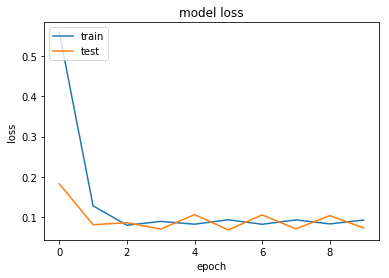

Train on 2850542 samples, validate on 1221661 samples
Epoch 1/10
2850542/2850542 [==============================] - 12s 4us/step - loss: 0.2714 - mean_absolute_error: 0.2714 - val_loss: 0.1550 - val_mean_absolute_error: 0.1550
Epoch 2/10
2850542/2850542 [==============================] - 11s 4us/step - loss: 0.1258 - mean_absolute_error: 0.1258 - val_loss: 0.1006 - val_mean_absolute_error: 0.1006
Epoch 3/10
2850542/2850542 [==============================] - 12s 4us/step - loss: 0.1042 - mean_absolute_error: 0.1042 - val_loss: 0.1011 - val_mean_absolute_error: 0.1011
Epoch 4/10
2850542/2850542 [==============================] - 22s 8us/step - loss: 0.1115 - mean_absolute_error: 0.1115 - val_loss: 0.1410 - val_mean_absolute_error: 0.1410
Epoch 5/10
2850542/2850542 [==============================] - 11s 4us/step - loss: 0.1222 - mean_absolute_error: 0.1222 - val_loss: 0.0949 - val_mean_absolute_error: 0.0949
Epoch 6/10
2850542/2850542 [==============================] - 11s 4us/step - loss

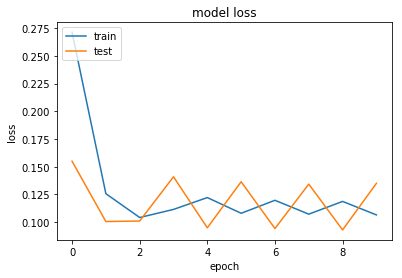

Train on 2850542 samples, validate on 1221661 samples
Epoch 1/10


In [ ]:
for degree in range(1,4):
# degree = 3
    X = modify_dataset(X, degree)
    lrmodel = getLinearRegressionModel(len(X.columns.values))
    history = lrmodel.fit(X,y, batch_size=1000000, epochs=10, validation_split=.3)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()